In [2]:
# imports for this notebook

from ananke.graphs import ADMG
from ananke.models import LinearGaussianSEM
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Structural Equation Models

The use of structural equation models and path analysis in causal models associated with a graph can be traced back to the works of [Sewall Wright](https://pdfs.semanticscholar.org/90bd/1ea6df6cf7ff14c392818751270b93d53d4e.pdf) and [Trygve Haavelmo](https://www.jstor.org/stable/pdf/1905714.pdf?refreqid=excelsior%3Ad280a758d3b0b296a15540bc7cf0a312). In this notebook we demonstrate how graphical models can be used to postulate causal mechanisms in the presence of confounding, and provide examples of model selection, and computation of causal effects.

Given an ADMG ${\cal G}$, the linear structural equation model with correlated errors (SEM) associated with ${\cal G}$ is defined as the set of multivariate normal distributions with covariance matrices of the form

$\Sigma = (I − B)^{-T}\Omega(I − B)^{-1}$,

where $\omega_{ij} = \omega_{ji} = 0$ unless $i \leftrightarrow j$ exists in ${\cal G}$, and $b_{ij} =
0$ unless $j \rightarrow i$ exists in ${\cal G}$. The matrix $\Omega$ and therefore $\Sigma$ is assumed to be positive semi-definite. Since ${\cal G}$ is acyclic, $B$ is assumed to be lower triangular.

# Arid Graphs

Before going further, it is important to define the class of graphs that we will be working with because statistical models associated with arbitrary Acyclic Directed Mixed Graphs (ADMGs) are not always identified. However, it has been shown by [Drton, Foygel, and Sullivant](https://projecteuclid.org/download/pdfview_1/euclid.aos/1299680957) that SEMs associated with a certain class of ADMGs that lack convergent aborescences or C-trees, hence the coinage arid graphs, are everywhere identified. Here, we will focus on linear SEMs associated with **Maximal Arid Graphs (MArGs)** introduced by [Shpitser, Evans, and Richardson](http://auai.org/uai2018/proceedings/papers/255.pdf) and use the maximal arid projection defined therein, in order to convert a non-arid ADMG to the corresponding MArG that implies the same conditional and nested Markov constraints.

Consider the non-arid graph ${\cal G}$ below.

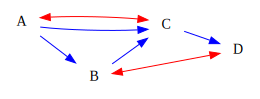

In [3]:
# create a non-arid graph
# the bow arc A->C, A<->C is a C-tree
vertices = ["A", "B", "C", "D"]
di_edges = [("A", "B"), ("A", "C"), ("B", "C"), ("C", "D")]
bi_edges = [("A", "C"), ("B", "D")]
G = ADMG(vertices, di_edges=di_edges, bi_edges=bi_edges)
G.draw(direction="LR")

We can obtain the corresponding maximal arid projection ${\cal G}^\dagger$ like so.

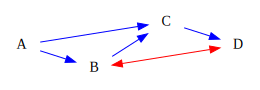

In [4]:
G_arid = G.maximal_arid_projection()
G_arid.draw(direction="LR")

# Fitting and Causal Effect Estimation

We now demonstrate how to fit data originating from a system of linear structural equation models associated with an ADMG, as defined in the first section of the notebook. We first generate data according to a linear SEM associated with the MArG ${\cal G}^\dagger$ above.

In [5]:
# define number of samples and number of vertices
N = 5000
dim = 4

# define the Omega matrix
omega = np.array([[1, 0, 0, 0],
                  [0, 1, 0, 0.8],
                  [0, 0, 1, 0],
                  [0, 0.8, 0, 1]])

# define the B matrix
beta = np.array([[0, 0, 0, 0],
                 [3, 0, 0, 0],
                 [1.2, -1, 0, 0],
                 [0, 0, 2.5, 0]])


# generate data according to the graph
true_sigma = np.linalg.inv(np.eye(dim) - beta) @ omega @ np.linalg.inv((np.eye(dim) - beta).T)
X = np.random.multivariate_normal([0] * dim, true_sigma, size=N)
data = pd.DataFrame({"A": X[:, 0], "B": X[:, 1], "C": X[:, 2], "D": X[:, 3]})

We then check that we are able to recover the true parameters of the data generating distribution. The **LinearGaussianSEM** class has a special draw functionality to draw the associated MArG and label the parameters corresponding to each edge.

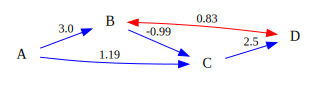

In [6]:
model = LinearGaussianSEM(G_arid)
model.fit(data)
model.draw(direction="LR")

We now compute some causal effects through simple path analysis. Consider the total causal effect of $D$ on $A$ and $A$ on $D$. The former is zero as expected, and the latter is obtained as the sum of contributions through all directed paths from $A$ to $D$ and should be close to the true value of -4.5.

In [7]:
print("E[A(d)] =", str(model.total_effect(["D"], ["A"])))
print("E[D(a)] =", str(model.total_effect(["A"], ["D"])))

E[A(d)] = 0
E[D(a)] = -4.449288494413542


To demonstrate what could go wrong when we use a non-arid graph. Consider fitting the same data utilizing a model associated with the non-arid graph ${\cal G}$ from before. We now see that our coefficient and causal estimates are now completely awry.

E[D(a)] = -46.43414373963806


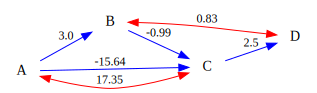

In [8]:
model = LinearGaussianSEM(G)
model.fit(data)
print("E[D(a)] =", str(model.total_effect(["A"], ["D"])))
model.draw(direction="LR")

# Model Selection

How do we pick the correct graphical model? Linear Gaussian SEMs associated with MArGs are **curved exponential families** and thus we can use the [BIC](https://en.wikipedia.org/wiki/Bayesian_information_criterion) score to test for goodness of fit. The graph ${\cal G}^\dagger$ implies a Verma constraint (a dormant conditional independence) where $A \amalg D$ in the kernel and associated CADMG obtained by fixing $C$. More formally,

$\phi_C\big(p(V); {\cal G}^\dagger\big) \equiv \frac{p(A, B, C, D)}{p(C| {\rm mb}(C))} = p(A, B)p(D|C)$,

where ${\rm mb}(C)$ is the Markov blanket of $C$. Consider a graph ${\cal G}_s$ which is the same as ${\cal G}^\dagger$ but with an additional directed edge $A \rightarrow D$. There are no conditional independences or Vermas implied by ${\cal G}_s$. That is, the model associated with ${\cal G}_s$ is a super model of the true model and contains one extra parameter associated with the extra directed edge. When choosing between these two hypotheses, the BIC should prefer ${\cal G}^\dagger$ as it is more parsimonious. Let's look at the comparison.

In [9]:
di_edges = [("A", "B"), ("A", "C"), ("B", "C"), ("C", "D"), ("A", "D")]
bi_edges = [("B", "D")]
G_saturated = ADMG(vertices, di_edges=di_edges, bi_edges=bi_edges)

# calculate BIC for the true model
model_truth = LinearGaussianSEM(G_arid)
model_truth.fit(data)
bic_truth = 2*model_truth.neg_loglikelihood(data) + model_truth.n_params*np.log(N)

# calculate BIC for the saturated model
model_saturated = LinearGaussianSEM(G_saturated)
model_saturated.fit(data)
bic_saturated = 2*model_saturated.neg_loglikelihood(data) + model_saturated.n_params*np.log(N)

print("BIC of the true model", bic_truth)
print("BIC of the saturated model", bic_saturated)
print("The BIC of the true model should be lower (better) than the saturated model.", bic_truth < bic_saturated)

BIC of the true model -24834.01118937594
BIC of the saturated model -24825.574924742836
The BIC of the true model should be lower (better) than the saturated model. True


What if we pick a (slightly) incorrect model where we posit that the observed correlation between $B$ and $D$ is due to a directed edge $B \rightarrow D$ instead of confounding? The BIC should prefer any super model of the truth to an incorrect model.

BIC of the incorrect model -20312.956108202907
The BIC of the true model should be lower (better) than the incorrect model. True


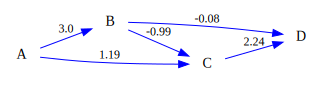

In [10]:
di_edges = [("A", "B"), ("B", "C"), ("C", "D"), ("B", "D"), ("A", "C")]
bi_edges = []
G_incorrect = ADMG(vertices, di_edges=di_edges, bi_edges=bi_edges)

# calculate BIC for incorrect model
model_incorrect = LinearGaussianSEM(G_incorrect)
model_incorrect.fit(data)
bic_incorrect = 2*model_incorrect.neg_loglikelihood(data) + model_incorrect.n_params*np.log(N)

print("BIC of the incorrect model", bic_incorrect)
print("The BIC of the true model should be lower (better) than the incorrect model.", bic_truth < bic_incorrect)
model_incorrect.draw(direction="LR")

Finally, we consider the most interesting scenario --  a model that encodes the exact same nested Markov constraints. It turns out that two nested Markov equivalent models will be statistically indistinguishable and their BIC scores will be exactly the same.

In [11]:
di_edges = [("A", "C"), ("B", "C"), ("C", "D")]
bi_edges = [("A", "B"), ("B", "D")]
G_equivalent = ADMG(vertices, di_edges=di_edges, bi_edges=bi_edges)

# calculate BIC for the nested Markov equivalent model
model_equivalent = LinearGaussianSEM(G_equivalent)
model_equivalent.fit(data)
bic_equivalent = 2*model_equivalent.neg_loglikelihood(data) + model_equivalent.n_params*np.log(N)

print("BIC of the equivalent model", bic_equivalent)
print("The difference in BIC =",
      round(abs(bic_equivalent - bic_truth), 2),
      "between equivalent models should be indistinguishable.")

BIC of the equivalent model -24834.011145886758
The difference in BIC = 0.0 between equivalent models should be indistinguishable.


What we've shown here is that the BIC score can be used to select between different hyoptheses. In DAG models, a greedy search procedure was posited by [Chickering](http://www.jmlr.org/papers/volume3/chickering02b/chickering02b.pdf) that surprisingly yields a globally optimal DAG model while greedily searching through the space of equivalence classes of DAGs. Such a greedy search procedure for nested Markov models is still an open problem -- indeed the question of nested Markov equivalence in itself is still an open problem.